In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle
import random

## Configuration parameters

In [2]:
#Data folder
data_dir='/home/malvarez/TFG2/Instrumentos/DataInput/WaveFiles/'

#Drawling folder
process_dir='/home/malvarez/TFG2/Instrumentos/DataInput/Preprocessed/'

#directory for training data and json file
train_dir=data_dir+'nsynth-train/'
#directory for training data and json file
valid_dir=data_dir+'/nsynth-valid/'
#directory for training data and json file
test_dir=data_dir+'/nsynth-test/'
#Json file used to analyze the data
filename='examples.json' #Put here the name of file (examples.json vs examplesEVA.json)

#Number of samples per family in the training set file. It should be lower than 5501, because class 9
#which is not used, has that maximal number of elements
nsamplesFamilyTrain=5000 #By default it was set to 5000, inc

nsamplesFamilyTest=0 #With 0 it picks all the set
nsamplesFamilyValid=0 #With 0 it picks all the set



# User Defined Functions

In [3]:
def feature_extract(file):
    """
    Define function that takes in a file an returns all the features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfccMAT = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfccMAT,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogramMAT = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogramMAT, axis = 1)
    
    #compute chroma energy
    chromaMAT = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chromaMAT, axis = 1)
    
    #compute spectral centroid
    centroidMAT = librosa.feature.spectral_centroid(y=y, sr=sr)
    #temporally average spectral centroid
    centroid = np.mean(centroidMAT, axis= 1)
    
    #compute spectral contrast
    contrastMAT = librosa.feature.spectral_contrast(y=y, sr=sr)
    #temporally average spectral contrast
    contrast = np.mean(contrastMAT, axis= 1)
    
    #compute spectral rolloff
    rolloffMAT = librosa.feature.spectral_rolloff(y=y, sr=sr)
    #temporally average spectral rolloff
    rolloff = np.mean(rolloffMAT, axis= 1)
    
    #compute zero crossing
    zcMAT = librosa.zero_crossings(y=y)
    #temporally average zero crossing
    zc = np.mean(zcMAT)
    
    #compute zero crossing rate
    zcrMAT = librosa.feature.zero_crossing_rate(y=y)
    #temporally average zero crossing rate
    zcr = np.mean(zcrMAT, axis= 1)

    #compute LPC
    lpcMAT = librosa.lpc(y, 2)
    #temporally average LPC
    lpc = np.mean(lpcMAT)
     
    
    return [harmonic, mfcc, spectrogram, chroma, centroid, contrast, rolloff, zc, zcr, lpc, mfccMAT, spectrogramMAT, chromaMAT, centroidMAT,  contrastMAT, rolloffMAT, zcMAT, zcrMAT, lpcMAT]

In [4]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    
    return None

In [5]:
def process_dataset(label,dataset_folder,fname,process_dir,nsamplesFamily):
    """
    Function that performs all the proccesing of a set (train, test or validation)
    """
    
    #Loads JSON File, where the wave files are selected
    df_set_raw = pd.read_json(path_or_buf=dataset_folder+fname, orient='index')
    
    #It shows how many elements of each class are
    n_class= df_set_raw['instrument_family'].value_counts(ascending=True)
    
    #If we provide a possitive number of samples, we don't select all, just the given number for each
    if nsamplesFamily>0:
        
        u=nsamplesFamily
        sampling=True

        #Checking if the nsamples are available in all the sets
        for i in n_class.index.unique(): 
            
            if n_class[i]<nsamplesFamily : 
                print('Class {} has only {} elements and you are trying to sample {}'.format(i,n_class[i],nsamplesFamily))
                if n_class[i]<u:
                    u=n_class[i]
                sampling=False
        
        if sampling==False:
            raise Exception('You need to make nsamplesFamily smaller than {}'.format(u));
        
        df_set=df_set_raw.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(nsamplesFamily)) #number of samples  
    else:
        df_set=df_set_raw
    
    #Eliminates examples of class 9
    df_set= df_set[df_set['instrument_family']!=9]
    
    filenames_set = df_set.index.tolist()
    
    #Suffle filenames, they shall not be sorted by names
    random.shuffle(filenames_set)
    
    
    #save the list of instruments to a pickle file
    with open(process_dir+'filenames_'+label+'.pickle', 'wb') as f:
        pickle.dump(filenames_set, f)
            
    #Create a dictionary to extract features in all the files       
    dict_set = {}
    #loop over every file in the list
   
    hm= len(filenames_set)
    for file, i in zip(filenames_set,range(hm)):
        #extract the features
        features = feature_extract(dataset_folder+'audio/'+file + '.wav') #specify directory and .wav
        #add dictionary entry
        dict_set[file] = features
        #Print progress in the console
        str1="Processing file {}/{}".format(i,hm)
        print(str1, end="\r")
            
    #convert dict to dataframe
    features_set = pd.DataFrame.from_dict(dict_set, orient='index',
                                        columns=['harmonic','mfcc','spectro','chroma','centroid','contrast','rolloff','zc','zcr','lpc','mfccMAT','spectroMAT','chromaMAT','centroidMAT','contrastMAT','rolloffMAT','zcMAT','zcrMAT','lpcMAT'])

    #In this part we obtain all the numberic features and change its organization to build a unique row of the matrix
    
    #extract mfccs
    mfcc_set = pd.DataFrame(features_set.mfcc.values.tolist(),index=features_set.index)
    mfcc_set = mfcc_set.add_prefix('mfcc_')

    #extract spectro
    spectro_set = pd.DataFrame(features_set.spectro.values.tolist(),index=features_set.index)
    spectro_set = spectro_set.add_prefix('spectro_')

    #extract chroma
    chroma_set = pd.DataFrame(features_set.chroma.values.tolist(),index=features_set.index)
    chroma_set = chroma_set.add_prefix('chroma_')    
    
    #extract centroid
    centroid_set = pd.DataFrame(features_set.centroid.values.tolist(),index=features_set.index)
    centroid_set = centroid_set.add_prefix('centroid_')

    #extract contrast
    contrast_set = pd.DataFrame(features_set.contrast.values.tolist(),index=features_set.index)
    contrast_set = contrast_set.add_prefix('contrast_')
    
    #extract rolloff
    rolloff_set = pd.DataFrame(features_set.rolloff.values.tolist(),index=features_set.index)
    rolloff_set = rolloff_set.add_prefix('rolloff_')
    
    #extract zc
    zc_set = pd.DataFrame(features_set.zc.values.tolist(),index=features_set.index)
    zc_set = zc_set.add_prefix('zc_')
    
    #extract zcr
    zcr_set = pd.DataFrame(features_set.zcr.values.tolist(),index=features_set.index)
    zcr_set = zcr_set.add_prefix('zcr_')
    
    #extract lpc
    lpc_set = pd.DataFrame(features_set.lpc.values.tolist(),index=features_set.index)
    lpc_set = lpc_set.add_prefix('lpc_')
    
    #Any other feature of the same type
    

    #This region is for the new matricial (image) features
    mfccMAT_set = features_set.mfccMAT.values
    spectroMAT_set = features_set.spectroMAT.values
    chromaMAT_set = features_set.chromaMAT.values
    centroidMAT_set = features_set.centroidMAT.values
    contrastMAT_set = features_set.contrastMAT.values
    rolloffMAT_set = features_set.rolloffMAT.values
    zcMAT_set = features_set.zcMAT.values
    zcrMAT_set = features_set.zcrMAT.values
    lpcMAT_set = features_set.lpcMAT.values

    #drop the old columns
    lab=['mfcc','spectro','chroma','centroid','contrast','rolloff','zc','zcr','lpc','mfccMAT','spectroMAT','chromaMAT','centroidMAT','contrastMAT','rolloffMAT','zcMAT','zcrMAT','lpcMAT']
    features_set = features_set.drop(labels=lab, axis=1)

    #concatenate the vectorial (non matrix features), if you have more, you can add them here
    df_features_set=pd.concat([features_set,mfcc_set,spectro_set,chroma_set,centroid_set,contrast_set,rolloff_set,zc_set,zcr_set,lpc_set],
                           axis=1, join='inner')

    
    #Prepare target file
    targets_set = []
    for name in df_features_set.index.tolist():
        targets_set.append(instrument_code(name))

    df_features_set['targets'] = targets_set

    #save the dataframe to a pickle file
    with open(process_dir+'df_features_'+label+'.pickle', 'wb') as f:
        pickle.dump(df_features_set, f)
    
    
    #We save the DN datafiles
    #Label file
    with open(process_dir+'Y_'+label+'.pickle', 'wb') as f:
        pickle.dump(np.array(targets_set), f)

    #Images files
    
    #Convert into a matrix of the correct dimensions: num_samples x (wx x wy)
    mfccMAT_set=np.stack(mfccMAT_set,axis=0) 
    with open(process_dir+'X_MFCC_'+label+'.pickle', 'wb') as f:
        pickle.dump(mfccMAT_set, f)
    
    spectroMAT_set=np.stack(spectroMAT_set,axis=0)
    with open(process_dir+'X_SPECTRO_'+label+'.pickle', 'wb') as f:
        pickle.dump(spectroMAT_set, f)
    
    chromaMAT_set=np.stack(chromaMAT_set,axis=0)
    with open(process_dir+'X_CHROMA_'+label+'.pickle', 'wb') as f:
        pickle.dump(chromaMAT_set, f)    
    
    centroidMAT_set=np.stack(centroidMAT_set,axis=0)
    with open(process_dir+'X_CENTROID_'+label+'.pickle', 'wb') as f:
        pickle.dump(centroidMAT_set, f)

    contrastMAT_set=np.stack(contrastMAT_set,axis=0)
    with open(process_dir+'X_CONTRAST_'+label+'.pickle', 'wb') as f:
        pickle.dump(contrastMAT_set, f)
        
    rolloffMAT_set=np.stack(rolloffMAT_set,axis=0)
    with open(process_dir+'X_ROLLOFF_'+label+'.pickle', 'wb') as f:
        pickle.dump(rolloffMAT_set, f)

    zcMAT_set=np.stack(zcMAT_set,axis=0)
    with open(process_dir+'X_ZC_'+label+'.pickle', 'wb') as f:
        pickle.dump(zcMAT_set, f)
    
    zcrMAT_set=np.stack(zcrMAT_set,axis=0)
    with open(process_dir+'X_ZCR_'+label+'.pickle', 'wb') as f:
        pickle.dump(zcrMAT_set, f)
        
    lpcMAT_set=np.stack(lpcMAT_set,axis=0)
    with open(process_dir+'X_LPC_'+label+'.pickle', 'wb') as f:
        pickle.dump(lpcMAT_set, f)
        
    # Create JSON FILES
    #extract qualities
    set_qual = pd.DataFrame(df_set_raw.qualities.values.tolist(), index= df_set_raw.index)

    #concatenate
    json=pd.concat([df_set_raw, set_qual],
                           axis=1, join='inner')

    json= json.drop(labels=['qualities'], axis=1)

    #save the dataframe to a pickle file
    with open(process_dir+'json_'+label+'.pickle', 'wb') as f:
        pickle.dump(json, f)
    
    return [df_set,df_features_set,n_class]

# Extract Features from Wave Files

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing mean
- zero crossing std
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness
- lpc mean
- lpc std

## Training set

The function below can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.
Besides, as we sample the training set, every time we run the following cell we are obtaining a different set of data for training

In [6]:
#Procces train set 
starttime=time.time()
json_features, numeric_features, n_class=process_dataset('train',train_dir,filename,process_dir,nsamplesFamilyTrain)
endtime= time.time()
print('Time to process {} files is {} seconds'.format(len(numeric_features), endtime - starttime))

C:\Users\alver\anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Time to process 500 files is 160.2600917816162 seconds


In [7]:
print(n_class) #Number of original classes in the json file

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64


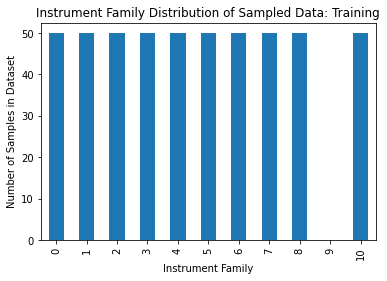

In [8]:
json_features['instrument_family'].value_counts().reindex(np.arange(0,len(n_class), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [9]:
json_features.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_115-043-100,249663,16000,43,2,bass,bass_synthetic_115,bass_synthetic_115-043-100,[fast_decay],synthetic,100,0,869,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
bass_synthetic_015-065-025,196039,16000,65,2,bass,bass_synthetic_015,bass_synthetic_015-065-025,[distortion],synthetic,25,0,229,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_082-039-100,204649,16000,39,2,bass,bass_synthetic_082,bass_synthetic_082-039-100,"[bright, distortion]",synthetic,100,0,722,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_072-033-050,154158,16000,33,2,bass,bass_synthetic_072,bass_synthetic_072-033-050,[distortion],synthetic,50,0,670,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_000-101-025,119539,16000,101,2,bass,bass_synthetic_000,bass_synthetic_000-101-025,[bright],synthetic,25,0,5,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [10]:
numeric_features.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,rolloff_0,zc_0,zcr_0,lpc_0,targets
brass_acoustic_062-041-025,0,-314.112030,231.063126,29.018843,-24.469727,-8.514785,-2.547920,-1.098820,-5.916578,-8.266499,...,24.275723,24.875633,21.909768,16.849076,49.651605,1074.544177,0.037302,0.036663,0.006212,1
flute_acoustic_024-067-025,0,-274.683563,52.423744,-52.399376,20.521128,-5.209689,18.693207,-8.449156,-7.702608,-17.181465,...,38.431155,31.493801,24.547661,18.687216,53.117658,1665.151395,0.037710,0.037431,0.007916,2
string_acoustic_029-063-075,1,-292.670044,77.405846,-54.221069,26.817837,-20.640152,-12.402453,-18.059286,-6.075867,-6.572363,...,30.851174,29.587411,23.505817,23.241046,56.388339,2482.666298,0.062676,0.062257,0.013644,8
vocal_acoustic_014-068-050,0,-408.128082,82.911453,31.430605,3.664012,-18.833286,-13.588190,-0.336032,-6.309835,-8.740088,...,38.059509,36.542584,21.621217,22.567099,51.107052,769.096313,0.037132,0.036901,0.005359,10
reed_acoustic_026-037-025,1,-559.657227,46.921009,8.611549,9.182067,-0.509672,1.010983,-0.839421,2.163283,5.008388,...,17.153395,17.789734,17.181900,17.087285,33.759401,806.188189,0.012880,0.012760,0.007576,7


In [11]:
len(numeric_features) #Number of samples in the file

500

## Testing Set

In this case, we dont sample the dataset, so we always obtain the same files, as far as we dont change the filename

In [12]:
#Procces testing set. last paremeter is 0 to avoid resampling
starttime= time.time()
json_features, numeric_features, n_class=process_dataset('test',test_dir,filename,process_dir,nsamplesFamilyTest) 
endtime= time.time()
print('Time to process {} files is {} seconds'.format(len(numeric_features), endtime - starttime))

Time to process 50 files is 15.607747077941895 seconds


In [13]:
print(n_class) #Number of original classes in the json file

10    141
2     180
5     202
7     235
1     269
8     306
6     502
3     652
4     766
0     843
Name: instrument_family, dtype: int64


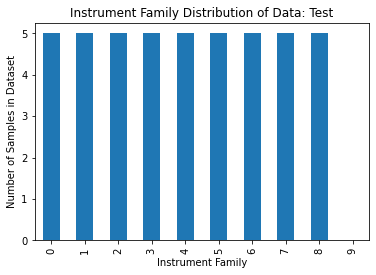

In [14]:
json_features['instrument_family'].value_counts().reindex(np.arange(0,len(n_class), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Data: Test")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [15]:
numeric_features.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,rolloff_0,zc_0,zcr_0,lpc_0,targets
organ_electronic_057-034-100,0,-424.077026,76.245125,48.664852,55.372086,49.345703,22.640114,14.039768,15.881274,7.658113,...,24.882534,20.939304,26.330089,27.840361,32.101926,343.659964,0.014229,0.014075,0.000381,6
bass_synthetic_134-080-127,1,-591.808289,19.170900,9.443770,5.143715,3.139107,1.661012,2.212529,4.037801,4.994255,...,11.742260,17.377381,14.904817,12.798109,19.416119,993.639078,0.035975,0.035597,0.003584,0
brass_acoustic_015-047-050,0,-449.102325,105.151100,22.351315,2.082809,-8.584585,-7.453054,-9.568241,-11.503002,-10.952703,...,26.365331,21.817416,20.711905,17.206827,42.319639,928.417122,0.040510,0.040268,0.008996,1
keyboard_electronic_078-080-075,1,-597.715149,29.703531,5.862395,10.041604,5.809229,3.758331,1.862949,15.437156,14.789240,...,18.577825,27.482592,24.742880,19.763905,48.659169,3280.452803,0.208968,0.207548,0.145645,4
keyboard_electronic_098-051-025,0,-451.979218,67.349442,46.257946,38.835899,23.098467,14.421375,14.979237,-0.826000,-14.951460,...,36.220608,24.232899,23.664355,28.009584,32.609874,367.060208,0.016247,0.016108,0.001243,4


In [16]:
len(numeric_features) #Number of samples in the file

50

## Validation Set

In this case, we dont sample the dataset, so we always obtain the same files, as far as we dont change the filename

In [17]:
#Procces testing set. last paremeter is 0 to avoid resampling
starttime = time.time()
json_features, numeric_features, n_class=process_dataset('valid',valid_dir,filename,process_dir,nsamplesFamilyValid)
endtime= time.time()
print('Time to process {} files is {} seconds'.format(len(numeric_features), endtime - starttime))

Time to process 50 files is 15.600295782089233 seconds


In [18]:
print(n_class) #Number of original classes in the json file

10     404
2      470
5      663
7      720
8      814
1      886
6     1598
3     2081
4     2404
0     2638
Name: instrument_family, dtype: int64


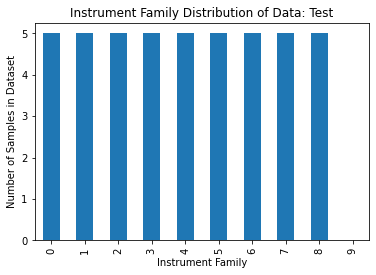

In [19]:
json_features['instrument_family'].value_counts().reindex(np.arange(0,len(n_class), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Data: Test")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [20]:
numeric_features.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,rolloff_0,zc_0,zcr_0,lpc_0,targets
organ_electronic_001-055-050,0,-426.273224,106.712730,33.820961,31.011379,26.764439,-5.538299,-19.524302,-14.299202,-15.067886,...,35.102571,25.715630,25.641279,26.389960,32.511416,627.823564,0.028163,0.027917,0.002507,6
flute_synthetic_000-065-100,0,-370.700745,48.976280,-19.347446,43.631920,17.318253,3.398996,9.459108,6.105326,-14.407580,...,18.478673,28.213219,24.319007,24.336499,53.560207,1916.766252,0.027177,0.026991,0.003343,2
bass_electronic_018-056-100,0,-508.813324,30.300688,19.361538,14.454925,10.467346,6.063028,2.464637,-0.927260,-3.555728,...,23.460172,15.853533,15.138543,14.218810,37.943752,1335.245298,0.071179,0.070694,0.002665,0
brass_acoustic_016-079-050,1,-417.299164,-28.214373,-28.000971,59.433571,-51.491467,36.869232,-44.413322,27.790661,9.654467,...,36.376416,32.398495,30.539267,35.963783,68.862546,5387.221567,0.371122,0.368937,0.560606,1
vocal_synthetic_003-050-127,0,-76.156113,19.330017,-115.003067,93.939987,-44.305878,47.682499,-38.041252,11.307947,-20.635262,...,34.930865,39.078409,38.560646,38.596949,72.465281,4926.622618,0.195635,0.193839,0.122842,10
